In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

In [2]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os


In [3]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than n_coll.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_fine, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

In [4]:
# n_coll_t = 30
# n_coll_x=30
n_obs = 50
run = 100

n_coll = 2500

tx_obs, u_obs, tx_all, u_star, X_star = (
    get_data_rand_coll(n_coll = n_coll,n_obs = n_obs,seed=run)
)
tx_all = jnp.vstack([tx_all,jnp.vstack([jnp.zeros(30),jnp.linspace(-8,8,30)]).T])

# Run 1_5 step method

u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[2.03724345 2.01946685]


In [6]:
# class OperatorModel():
#     def __init__(
#         self,
#         kernel,
#         nugget_size = 1e-7
#     ):
#         self.kernel_function = kernel
#         self.nugget_size = nugget_size

#     def predict(self,input_data,params):
#         K = self.kernel_function(input_data,input_data)
#         return K@params
        
#     def predict_new(self,X,anchors,params):
#         return self.kernel_function(X,anchors)@params
    
#     def fit_params(self,X,y,nugget = 1e-8):
#         K = self.kernel_function(X,X)
#         return jnp.linalg.solve(K + nugget * diagpart(K),y)
    
#     def rkhs_mat(self,X):
#         return self.kernel_function(X,X)


# class PolynomialModel(dimension,degree):
#     def pred


In [7]:
# # Equation model that has u and P object
# EqnModel = SplitOperatorPDEModel(
#     P_model,
#     (u_model,),
#     (tx_obs,),
#     (u_obs,),
#     (tx_all,),
#     feature_operators,
#     rhs_operator=dt_k,
#     datafit_weight = 100
# )

# # Optimize - LM
# params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
# params,convergence_data = CholeskyLM(
#     params_init.copy(),
#     EqnModel,
#     beta = 1e-11,
#     max_iter = 501,
#     init_alpha=0.1,
#     line_search_increase_ratio=1.4,
#     print_every = 100
# )
# p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,100,print_every = 10,overall_regularization=1e-15)
# # u_params
# u_sol = p_adjusted[:u_model.num_params]
# # u_true 
# u_true = u_star.flatten()
# # get error
# error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

In [8]:
# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

In [9]:
jit_valgrad = jax.jit(jax.value_and_grad(EqnModel.loss))
a = params_init
num_steps = 10000
fvals = []
for i in tqdm(range(num_steps)):
    val,g = jit_valgrad(a)
    a = a - 1e-7 * g
    fvals.append(val)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

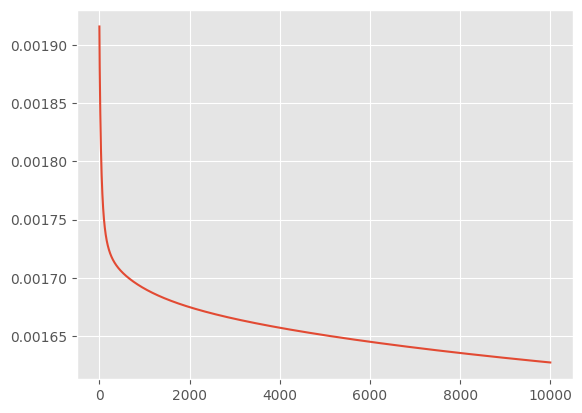

In [82]:
plt.plot(jnp.array(fvals))

In [83]:
rvec = jax.random.normal(jax.random.PRNGKey(13),shape = (200,2580))
primals,F_vjp = jax.vjp(EqnModel.F,params_init)
SJ = jax.vmap(F_vjp)(rvec)[0]
H = SJ.T@SJ + 1e-4 * jnp.identity(len(params_init))
primals,F_vjp = jax.vjp(EqnModel.F,params_init)


In [84]:
jit_valgrad = jax.jit(jax.value_and_grad(EqnModel.loss))

SJ = jax.vmap(F_vjp)(rvec)[0]
H = SJ.T@SJ + 1e-4 * jnp.identity(len(params_init))
primals,F_vjp = jax.vjp(EqnModel.F,params_init)

sketch = jax.random.normal(jax.random.PRNGKey(304),shape = (200,2580))

#@partial(jax.jit,static_argnames = 'size')

@jax.jit
def sketch_jac(params):
    primals,F_vjp = jax.vjp(EqnModel.F,params)
    SJ = jax.vmap(F_vjp)(sketch)[0]
    return SJ

In [85]:
from jax.scipy.linalg import solve

In [86]:
params = params_init
num_steps = 3000
fvals_SLM = []
for i in tqdm(range(num_steps)):
    val,g = jit_valgrad(params)
    SJ = sketch_jac(params)
    params = params - solve(SJ.T@SJ + 1e-2 * jnp.identity(len(params_init)),g,assume_a = 'pos')
    if i%100==0:
        print(f"Iteration {i}: ",val)
    fvals_SLM.append(val)
fvals_SLM = jnp.array(fvals_SLM)


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 0:  0.001916008528544531
Iteration 100:  0.0004703465178836351
Iteration 200:  0.00026766552415201557
Iteration 300:  0.00017153896223630392
Iteration 400:  0.00011700581221639579
Iteration 500:  8.33570374857959e-05
Iteration 600:  6.144897406027749e-05
Iteration 700:  4.660995838791763e-05
Iteration 800:  3.623418161813029e-05
Iteration 900:  2.8779928389939734e-05
Iteration 1000:  2.3295406862886016e-05
Iteration 1100:  1.9173478871631284e-05
Iteration 1200:  1.601638805188443e-05
Iteration 1300:  1.3557450669281933e-05
Iteration 1400:  1.1614005717135323e-05
Iteration 1500:  1.0058336939165463e-05
Iteration 1600:  8.799312475866383e-06
Iteration 1700:  7.770594239326738e-06
Iteration 1800:  6.9229574756093475e-06
Iteration 1900:  6.219221461235503e-06
Iteration 2000:  5.630857564912475e-06
Iteration 2100:  5.135683029636608e-06
Iteration 2200:  4.716261974802713e-06
Iteration 2300:  4.358771225686945e-06
Iteration 2400:  4.052176360325694e-06
Iteration 2500:  3.7876195197

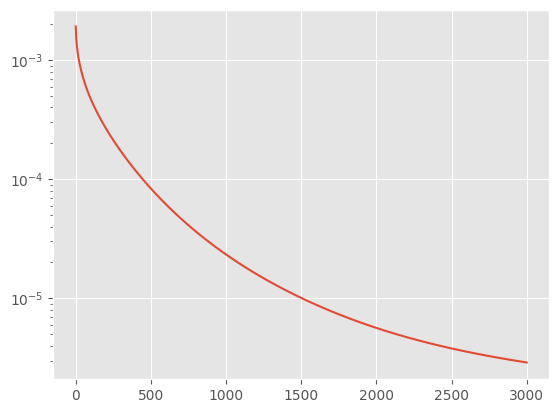

In [96]:
plt.plot(fvals_SLM)
plt.yscale('log')

In [97]:
u_sol = EqnModel.get_u_params(params)[0]
P_params = EqnModel.get_P_params(params)

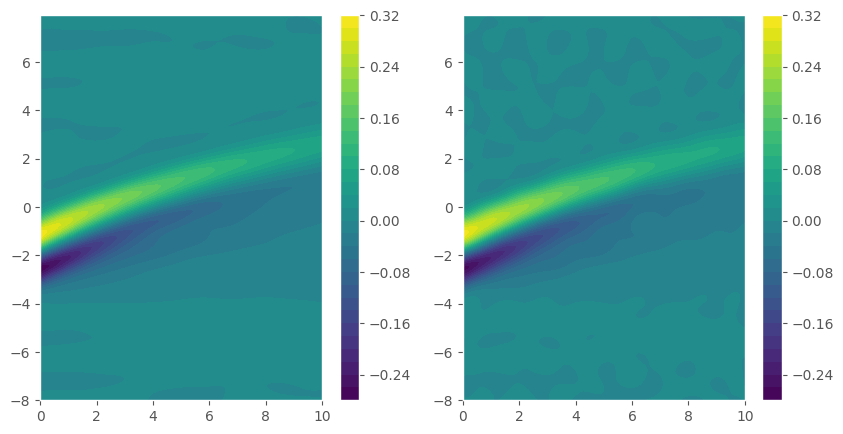

Text(0.5, 1.0, 'PDE error between ut from interpolant and predicted')

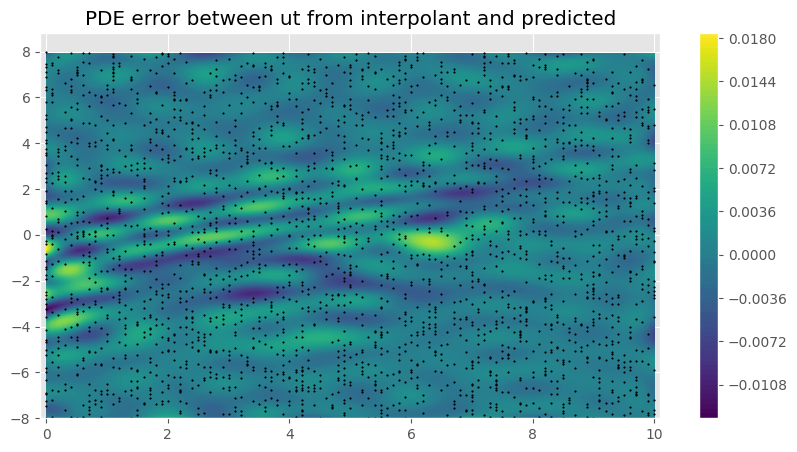

In [104]:
fine_features = EqnModel.single_eqn_features(u_model,u_sol,X_star)
input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all)

feature_predicted_ut = P_model.predict_new(fine_features,input_features,P_params)
ut_target = u_model.evaluate_operators((dt_k,),X_star,u_sol)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.tricontourf(X_star[:,0],X_star[:,1],feature_predicted_ut,30)
plt.colorbar()
plt.subplot(1,2,2)
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target,30)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,5))
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target - feature_predicted_ut,100)
plt.xlim(-0.1,10.1)
# plt.ylim(-10,10)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 1,label = 'collocation points')
plt.title("PDE error between ut from interpolant and predicted")


In [99]:
jnp.linalg.norm(ut_target - feature_predicted_ut)

Array(0.43537814, dtype=float64)

In [100]:
u_true = u_star.flatten()

In [101]:
error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

In [102]:
error_u_field

Array(0.07542992, dtype=float64)

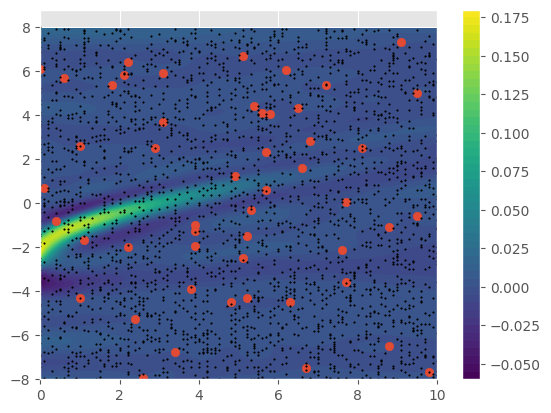

In [94]:
plt.tricontourf(X_star[:,0],X_star[:,1],u_true-u_model.point_evaluate(X_star,u_sol),50)
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 1)


In [95]:
error = u_model.point_evaluate(X_star,u_sol) - u_true

jnp.linalg.norm(error)/jnp.linalg.norm(u_true)

Array(0.07542992, dtype=float64)